In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
import matplotlib.pyplot as plt
from numpy import arange
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords as nlstopwords



## Data Pre-processing

* converted all words into lower case for uniformity
* Removed neutral reviews to only focus on positive and negative reviews




In [2]:
df = pd.read_csv('../input/twitter-airline-sentiment/Tweets.csv', usecols=['text', 'airline_sentiment'])
df['text'] = df['text'].str.lower()
df = df[df['airline_sentiment'] != 'neutral']
df['airline_sentiment'] = df['airline_sentiment'].str.replace('positive', '1')
df['airline_sentiment'] = df['airline_sentiment'].str.replace('negative', '0')

In [3]:
eda = pd.read_csv('../input/twitter-airline-sentiment/Tweets.csv')

In [4]:
eda.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


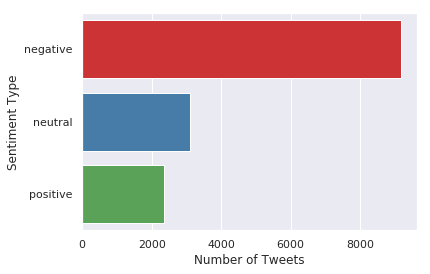

In [5]:
sns.set(style='darkgrid')
type_count = eda['airline_sentiment'].value_counts()
type_names = ['negative', 'neutral', 'positive']
tick_positions = [1,2,3]
ax = sns.barplot(x=type_count, y=type_names, palette='Set1', orient='h')
ax.set(xlabel='Number of Tweets', ylabel='Sentiment Type')

plt.show()

The data is heavily skewed with negative tweets making up about 63% of the tweets. When we train the model, this may lead to the classifier having a much easier time classifying negative tweets compared to positive ones. In terms of real tweets, this is expected because multiple studies have proven that people are more likely to tweet or report their negative experiences than positive ones. So while this dataset may be representative of the sentiment distribution of tweets, it is not ideal for training a model.

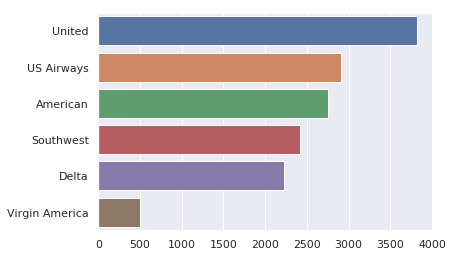

In [46]:
air_x = eda['airline'].value_counts().index
air_y = eda['airline'].value_counts().values
sns.barplot(x=air_y, y=air_x)

United is by far the most popular airline in terms of tweets, having nearly 1000 more tweets than the second most popular airline, US Airways.

In [6]:
eda.describe(include=['O'])

,airline_sentiment,negativereason,airline,airline_sentiment_gold,name,negativereason_gold,text,tweet_coord,tweet_created,tweet_location,user_timezone
count,14640,9178,14640,40,14640,32,14640,1019,14640,9907,9820
unique,3,10,6,3,7701,13,14427,832,14247,3081,85
top,negative,Customer Service Issue,United,negative,JetBlueNews,Customer Service Issue,@united thanks,"[0.0, 0.0]",2015-02-24 09:54:34 -0800,"Boston, MA",Eastern Time (US & Canada)
freq,9178,2910,3822,32,63,12,6,164,5,157,3744


In [7]:
eda.isnull().sum() / len(eda) * 100

tweet_id                         0.000000
airline_sentiment                0.000000
airline_sentiment_confidence     0.000000
negativereason                  37.308743
negativereason_confidence       28.128415
airline                          0.000000
airline_sentiment_gold          99.726776
name                             0.000000
negativereason_gold             99.781421
retweet_count                    0.000000
text                             0.000000
tweet_coord                     93.039617
tweet_created                    0.000000
tweet_location                  32.329235
user_timezone                   32.923497
dtype: float64

The columns ** text, airline_sentiment, and negative_reason** are the three features I would be focusing on to explore the reasons behind a tweet. Because positive and neutral tweets will have missing data in the **negative_reason** column, it is expected that the **negative_reason** column has about 37% missing values.

In [8]:
air_names = eda['airline'].unique()
print(air_names)

['Virgin America' 'United' 'Southwest' 'Delta' 'US Airways' 'American']


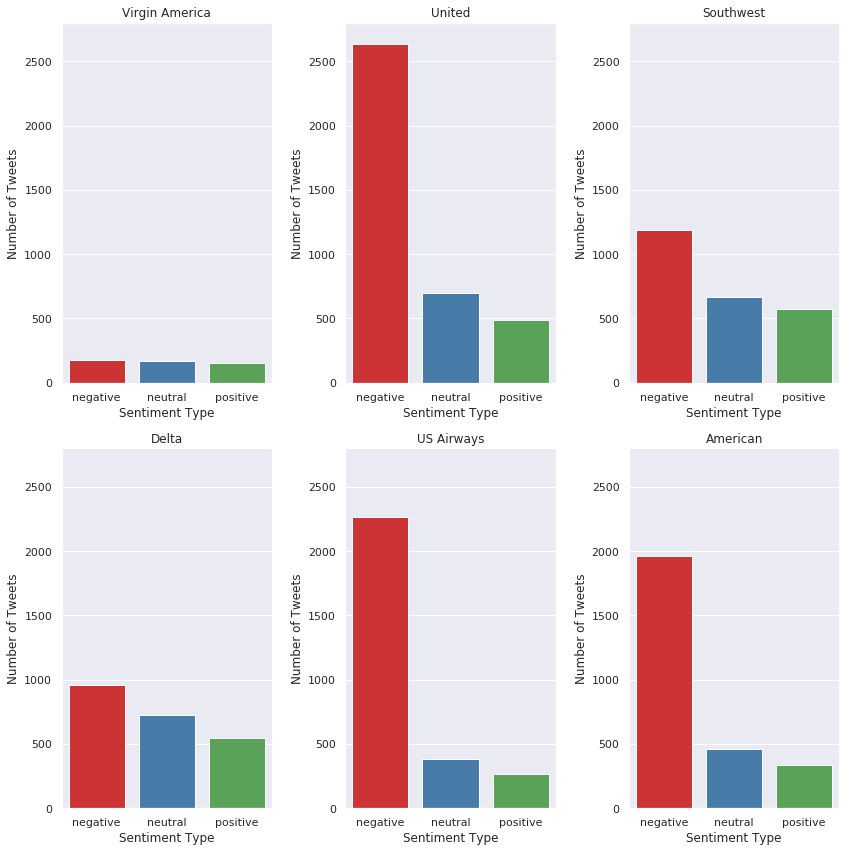

In [9]:
sns.set(style='darkgrid')
def my_plotting(airline_name, axis):
    current_frame = eda[eda['airline'] == airline_name]
    labels = current_frame['airline_sentiment'].value_counts().index.tolist()
    sentiment_count = current_frame['airline_sentiment'].value_counts()
    ax = sns.barplot(x=labels, y=sentiment_count, palette='Set1')
    ax.set(xlabel='Sentiment Type', ylabel='Number of Tweets')
    ax.set(ylim=(0,2800))
    plt.tight_layout()
    plt.title(airline_name)

index = 1
fig = plt.figure(1, figsize=(12,12))

for name in air_names:
    current_axis = fig.add_subplot(2,3,index)
    my_plotting(name, current_axis)
    index += 1


Virgin America seems to have the most balanced distribution of reviews categorized by sentiment but the much lower number of tweets compared to other airlines might indicate that it is not as popular as the other airlines in this dataset. United, U.S. Airways, and American have significantly more negative reviews than neutral or positive ones with United having more negative reviews than Southwest and Delta combined.

Now, let's take a look at the common reasons identified for negative tweets. Positive and neutral tweets don't have a negative reason listed so I will be dropping rows that are missing a value for **negativereason**.

In [47]:

dropped = eda.dropna(subset=['negativereason'])
dropped['negativereason'].value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

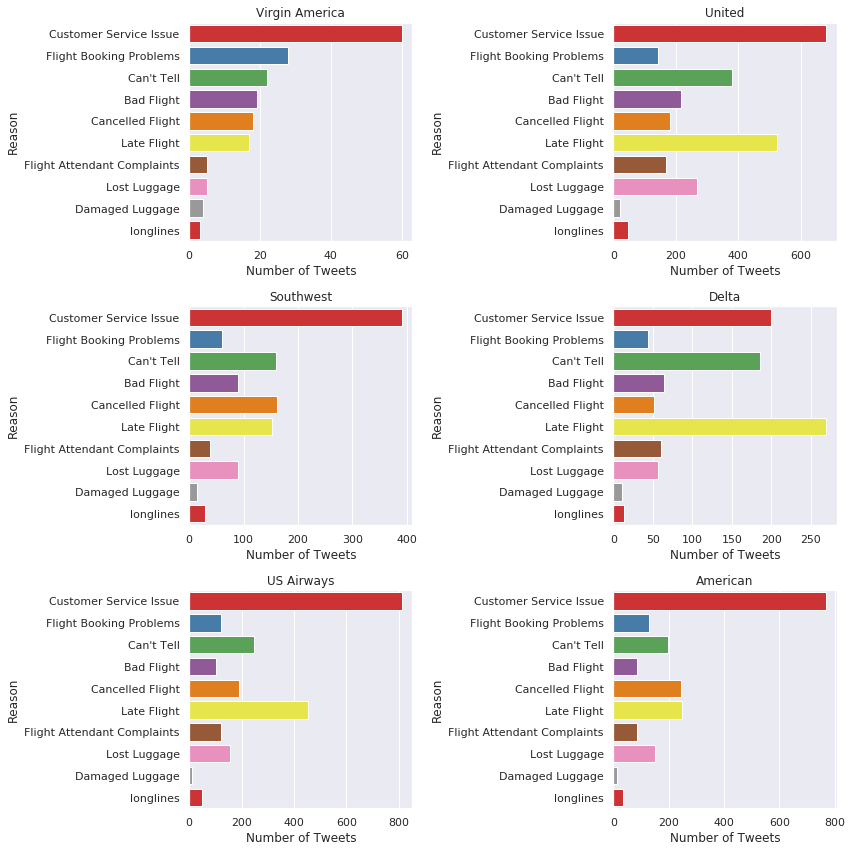

In [12]:
sns.set(style='darkgrid')

def my_plotting(airline_name, axis):
    default_labels = dropped[dropped['airline'] == 'Virgin America']['negativereason'].value_counts().index.tolist()
    my_count = []
    current_frame = dropped[dropped['airline'] == airline_name]
    current_labels = current_frame['negativereason'].value_counts().index.tolist()
    current_count = current_frame['negativereason'].value_counts()
    my_dictionary = dict(zip(current_labels, current_count))
    
    for lbl in default_labels:
        my_count.append(my_dictionary.get(lbl))
        
    #ax = sns.barplot(x=default_labels, y=my_count, palette='Set1')
    ax = sns.barplot(x=my_count, y=default_labels, palette='Set1', orient='h')
    ax.set(xlabel='Number of Tweets', ylabel='Reason')
    #ax.set(ylim=(0,900))
    plt.tight_layout()
    plt.title(airline_name)

index = 1
fig = plt.figure(1, figsize=(12,12))

for name in air_names:
    current_axis = fig.add_subplot(3,2,index)
    my_plotting(name, current_axis)
    index += 1


With the exception of Delta whose primary issue is a late flight, every airline's primary concern is customer service. Furthermore, flights that are cancelled or late are the next big concern for every airline. As mentioned earlier, Virgin America has the lowest negative tweets overall though this could also be attributed to less customers flying Virgin America. 

In [13]:
## Adding additional stopwords to pass to the WordCloud function

list_words = list(STOPWORDS)
for name in air_names:
    list_words.append(name)
list_words.append('AmericanAir')
list_words.append('SouthwestAir')
list_words.append('USAirways')
list_words.append('JetBlue')
list_words.append('flight')
list_words.append('airline')
list_words.append('VirginAmerica')
list_words = set(list_words)




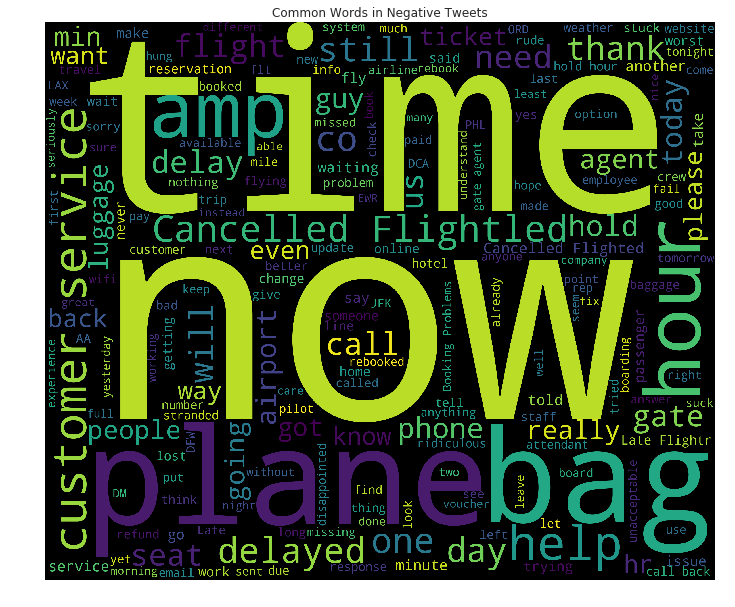

In [14]:
## Wordcloud for Negative Tweets

negative_col = eda[eda['airline_sentiment'] == 'negative']['text'] 
cleaned = ' '.join(negative_col)

wordcloud = WordCloud(width=3000,
                      height=2500,
                      stopwords=list_words,
                      background_color='black',
                     ).generate(cleaned)

plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.title('Common Words in Negative Tweets')
plt.axis('off')
plt.show()

A quick look at the word map above shows that some of the most commonly used words are **hour, flight cancelled, time, customer service, late flight and help.** Most of these words indicate an issue with delayed or cancelled flights. This isn't surprising because looking back at the bar graphs earlier where I compared each airline's negative reasons, late flight and cancelled flights together make up a significant part of an airline's negative tweets after customer service. Since customer service is a personalized issue, it is less likely for customer service tweets to share common words hence why the most common words in the wordmap are those that have to do with time.

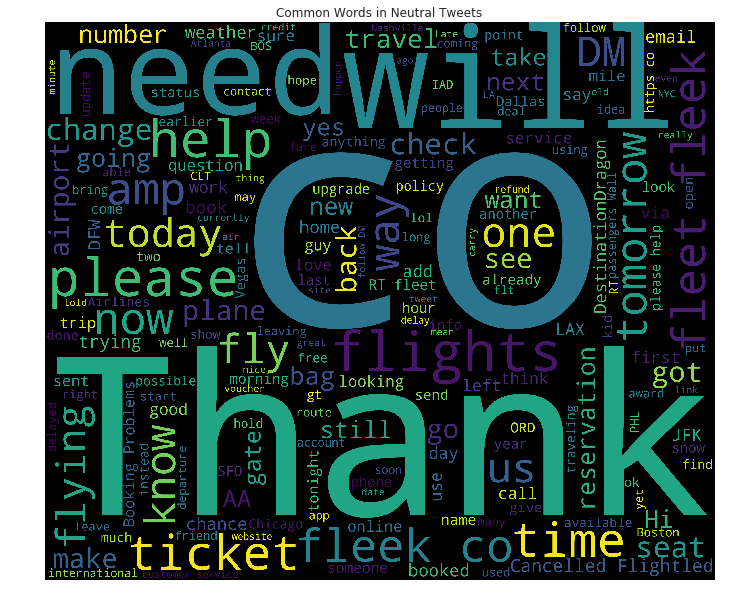

In [15]:
## WordCloud for Neutral Tweets

neutral_col = eda[eda['airline_sentiment'] == 'neutral']['text'] 
cleaned = ' '.join(neutral_col)

wordcloud = WordCloud(width=3000,
                      height=2500,
                      stopwords=list_words
                     ).generate(cleaned)

plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.title('Common Words in Neutral Tweets')
plt.axis('off')
plt.show()

Something interesting from this word cloud is that the term **Cancelled Flightled** is relatively common. I would expect most people tweeting about cancelled flights to likely be angry so seeing tweets about this topic classified as neutral is interesting. In order to double check to see if perhaps these were just misclassified tweets, I am going to take a look at neutral tweets that include the keyword "Cancelled."

In [55]:
neutral_series = eda[eda['airline_sentiment'] == 'neutral']['text'] 
tweet_list = [tweet for tweet in neutral_series if "Cancelled" in tweet ]
tweet_list

['@VirginAmerica is flight 882 Cancelled Flightled and what do I do if it is?',
 '@VirginAmerica  - Is Flight 713 from Love Field to SFO definitely Cancelled Flightled for Monday, February 23?',
 '@VirginAmerica nervous about my flight from DC to LAX getting Cancelled Flightled tomorrow! Just sent you a DM to help me!',
 '@VirginAmerica - can you tweet me the Cancelled Flight/chng fee for a flight? or can I rebook under one of your affiliates? If so, who are afiliates?',
 "@united Cancelled Flighted our flight, didn't rebook us on added flight, now have to drive from a Denver to KC....thanks!",
 '@united I have a 0530 flight out of DFW on Tuesday. How far in advance will you give notice if Cancelled Flightled?',
 '@united What are the chances of my flight to EWR from PIT being Cancelled Flighted tomorrow?',
 '@united flight to DFW from IAD Cancelled Flightled for mechanical can I get rental car to MDT-my origin',
 "@united you friend's flt from ase to Denver is Cancelled Flightled for 

Looking at some of these tweets, it makes sense that neutral tweets also have the keyword **Cancelled** in them because people often tweet questions regarding cancelled flights and these tweets would rightfully be classified as neutral.

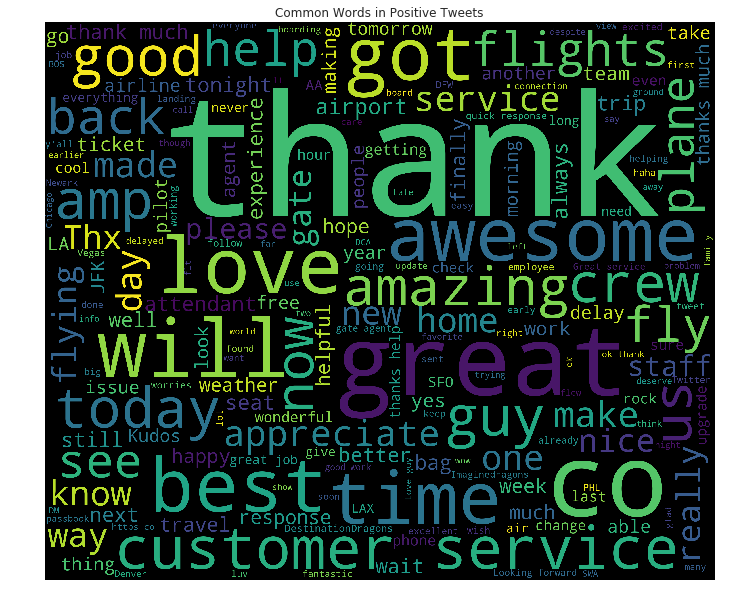

In [16]:
## WordCloud for Positive Tweets
positive_col = eda[eda['airline_sentiment'] == 'positive']['text'] 
cleaned = ' '.join(positive_col)

wordcloud = WordCloud(width=3000,
                      height=2500,
                      stopwords=list_words
                     ).generate(cleaned)

plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.title('Common Words in Positive Tweets')
plt.axis('off')
plt.show()

The common words for positive tweets are as expected. Moving on though, I am going to test if there is any relationship between negative tweets and the time of day.

In [18]:

copy_df = eda.copy()
copy_df['tweet_created']= pd.to_datetime(copy_df['tweet_created']) 
copy_df = copy_df.set_index('tweet_created')
copy_df.sort_index()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_location,user_timezone
tweet_created,,,,,,,,,,,,,,
2015-02-17 07:36:05,567588278875213824,neutral,1.0000,NaN,NaN,Delta,NaN,JetBlueNews,NaN,0,@JetBlue's new CEO seeks the right balance to ...,NaN,USA,Sydney
2015-02-17 07:43:02,567590027375702016,negative,1.0000,Can't Tell,0.6503,Delta,NaN,nesi_1992,NaN,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,NaN,undecided,Pacific Time (US & Canada)
2015-02-17 07:48:48,567591480085463040,negative,1.0000,Late Flight,0.3460,United,NaN,CPoutloud,NaN,0,@united yes. We waited in line for almost an h...,NaN,"Washington, DC",NaN
2015-02-17 07:52:20,567592368451248130,negative,1.0000,Late Flight,1.0000,United,NaN,brenduch,NaN,0,@united the we got into the gate at IAH on tim...,NaN,NaN,Buenos Aires
2015-02-17 08:00:36,567594449874587648,negative,1.0000,Customer Service Issue,0.3451,Southwest,NaN,VahidESQ,NaN,0,@SouthwestAir its cool that my bags take a bit...,NaN,"Los Angeles, CA",Pacific Time (US & Canada)
2015-02-17 08:01:07,567594579310825473,negative,1.0000,Bad Flight,0.6707,United,NaN,brenduch,NaN,0,@united and don't hope for me having a nicer f...,NaN,NaN,Buenos Aires
2015-02-17 08:05:27,567595670463205376,negative,1.0000,Late Flight,1.0000,United,NaN,CRomerDome,NaN,0,@united I like delays less than you because I'...,NaN,"Portland, OR",Pacific Time (US & Canada)
2015-02-17 09:18:29,567614049425555457,negative,1.0000,Customer Service Issue,0.3545,United,NaN,JustOGG,NaN,0,"@united, link to current status of flights/air...",NaN,Tweets = My Opinion,Eastern Time (US & Canada)
2015-02-17 09:30:32,567617081336950784,negative,1.0000,Customer Service Issue,1.0000,Southwest,NaN,mrshossruns,NaN,0,@SouthwestAir you guys there? Are we on hour 2...,NaN,NaN,Eastern Time (US & Canada)


In [20]:

times_list = []
labs = []
for i in range(0,24):
    time_string = str(i) + ':00:00'
    times_list.append(time_string)


neg_list = []
positive_list = []
for i in range(0,24):
    if(i == 23):
        neg_df = copy_df.between_time(times_list[i], times_list[0])

    else:
        neg_df = copy_df.between_time(times_list[i], times_list[i+1])
        
    neg_vals = neg_df['airline_sentiment'].value_counts().values[0]
    pos_vals = neg_df['airline_sentiment'].value_counts().values[2]
    neg_list.append(neg_vals)
    positive_list.append(pos_vals)


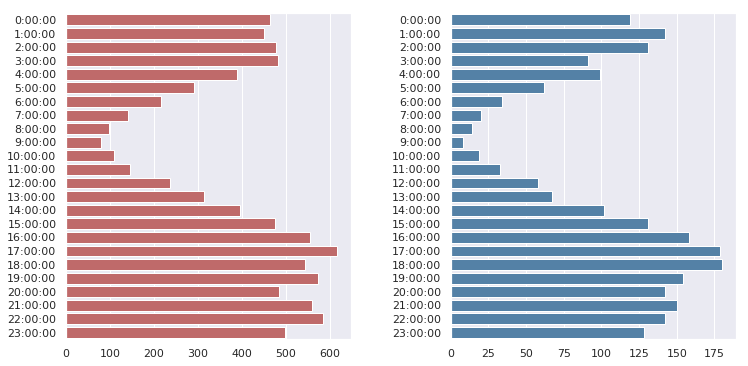

In [21]:
fig = plt.figure(1, figsize=(12,6))
fig.add_subplot(1,2,1)
fig.subplots_adjust(wspace=0.35)
sns.barplot(x=neg_list, y=times_list, orient='h', color='indianred')
fig.add_subplot(1,2,2)
sns.barplot(x=positive_list, y=times_list, orient='h', color='steelblue')


Both positive and negative tweets share a relatively identical tweet distribution throughout the day. Usually, morning is the time when the lowest number of people tend to tweet while evenings represent the peak time for tweets. It is a little surprising though that hours between midnight and 4 AM have more tweet activity than morning hours.

Now that I know how times affect tweets, I also want to analyze the distribution of tweets over all the days in the dataset.

In [23]:
date = eda.copy()
date.tweet_created = pd.to_datetime(date.tweet_created)
date.tweet_created = date.tweet_created.dt.date
date.tweet_created.head()
day_df = date.groupby(['tweet_created','airline','airline_sentiment']).size()
day_df = day_df.loc(axis=0)[:,:,'negative']
fin_df = day_df.groupby(['tweet_created','airline']).sum().unstack()
fin_df['tweet_created'] = fin_df.index.to_series()

In [28]:

melted_df = pd.melt(fin_df, id_vars='tweet_created', var_name='Airlines', value_name='Negative Tweets')

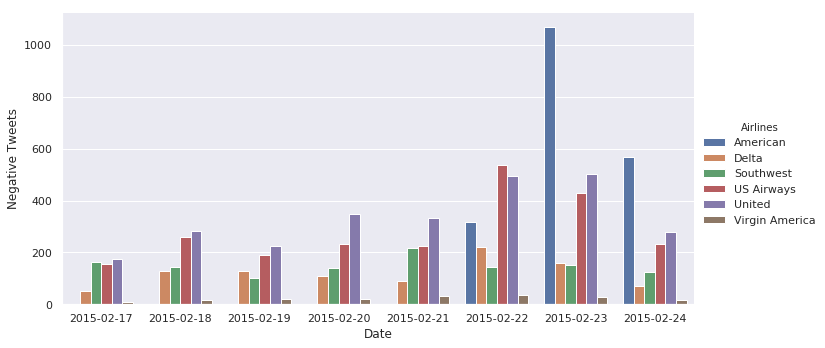

In [31]:

ax = sns.catplot(x='tweet_created', y='Negative Tweets', hue='Airlines', data=melted_df, kind='bar', height=5, aspect=2)
ax.set(xlabel='Date')


Looking at negative tweets by date, the most surprising thing is that American has no negative tweets from 2/17 to 2/21 but has a very large spike in negative tweets on 2/23. Doing some research revealed that on February 23, 2015, the Dallas/Fort Worth Airport had about 1,100 flights cancelled due to a storm. With DFW as the biggest hub of American Airlines, most of the cancelled flights were from American Airlines so it's understandable that American had a sharp increase in negative tweets on this day.

**Splitting the dataset into train/validation/test sets at a 60:20:20 ratio **

In [32]:
train, validate, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

In [33]:
train_sentences = train['text'].values
train_labels = train['airline_sentiment'].values

validation_sentences = validate['text'].values
validation_labels = validate['airline_sentiment'].values

test_sentences = test['text'].values
test_labels = test['airline_sentiment'].values



**Hyperparameters**

In [34]:
embedding_dim = 100
max_length = 16
padding_type='post'
trunc_type = 'post'
oov_tok = '<OOV>'

In [35]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
vocab_size = len(word_index)

sequences = tokenizer.texts_to_sequences(train_sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## Using Stanford's Glove to Create an Embedding Matrix

The dataset used for this project is small and consequently has a small number of words, which can lead to overfitting. Embeddings derived from this dataset can be overgeneralized so I decided to use transfer learning and import Stanford's Glove to use a pre-trained set of embeddings to help improve model performance.

In [36]:
embeddings_index = {}
with open("../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [38]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 10
history = model.fit(padded, train_labels, epochs=num_epochs, validation_data=(validation_padded, validation_labels), verbose=1)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 16, 100)           983600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 100)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 16, 128)           84480     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,110,353
Trainable params: 126,753
Non-trainable params: 983,600
________________________________________

In [39]:
test_accuracy = model.evaluate(testing_padded, test_labels)
print('Test accuracy of model is : {0:.2f}%'.format(test_accuracy[1]*100))

2309/2309 [==============================] - 1s 350us/sample - loss: 0.2570 - acc: 0.9021
Test accuracy of model is : 90.21%


<Figure size 432x288 with 0 Axes>

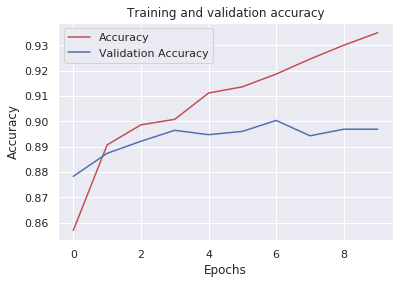

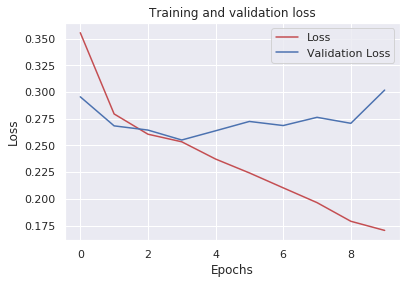

<Figure size 432x288 with 0 Axes>

In [40]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(num_epochs) # Get number of epochs

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
